# Installs all required Python libraries and system dependencies for the project.

In [10]:

!pip install -q --upgrade numpy scipy lightgbm dowhy aif360 networkx node2vec kaggle
!pip install 'aif360[all]'
!apt-get -qq install -y graphviz libgraphviz-dev
!pip install -q pygraphviz pydot


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
Selecting previously unselected package libgtk2.0-common.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.33-2ubuntu2.1_all.deb ...
Unpacking libgtk2.0-common (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail18:amd64.
Preparing to unpack .../2-libgail18_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail18:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libgail-common:amd64.
Preparing to unpack .../3-libgail-common_2.24.33-2ubuntu2.1_amd64.deb ...
Unpacking libgail-common:amd64 (2.24.33-2ubuntu2.1) ...
Selecting previously unselected package libxdot4:amd64.
Preparing to unpack .../4-libxdot4_2.42.2-6ubuntu0.1_am

# Imports the necessary libraries for data manipulation, modeling, causality, and fairness.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix,  classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


# Causal Inference
import dowhy
from dowhy import CausalModel

# Fairness (AIF360)
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

# Authenticates with the Kaggle API to download and load the PaySim transaction dataset.

In [2]:
# Install the Kaggle library
from google.colab import files
print("Please upload your kaggle.json file:")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ealaxi/paysim1

!unzip -q paysim1.zip

df = pd.read_csv("PS_20174392719_1491204439457_log.csv")
print("\nDataset loaded successfully!")
df.head()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ealaxi/paysim1
License(s): CC-BY-SA-4.0
 57% 101M/178M [00:00<00:00, 1.05GB/s]
100% 178M/178M [00:00<00:00, 825MB/s] 

Dataset loaded successfully!


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Performs feature engineering by sampling the data, building a graph, and generating Node2Vec embeddings.

In [3]:
# Keep relevant cols
df = df[['type','amount','nameOrig','oldbalanceOrg','newbalanceOrig',
         'nameDest','oldbalanceDest','newbalanceDest','isFraud']]

# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], prefix='tx')

# Create simple temporal features
df['tx_id'] = np.arange(len(df))

# Graph construction
sample_df = df.sample(60000, random_state=42)

G = nx.from_pandas_edgelist(sample_df,
                            source='nameOrig',
                            target='nameDest',
                            edge_attr=['amount'],
                            create_using=nx.DiGraph())

# Original Graph Features
deg = dict(G.degree())
clust = nx.clustering(G.to_undirected())
sample_df['deg_orig'] = sample_df['nameOrig'].map(deg)
sample_df['deg_dest'] = sample_df['nameDest'].map(deg)
sample_df['clust_orig'] = sample_df['nameOrig'].map(clust)
sample_df['clust_dest'] = sample_df['nameDest'].map(clust)

# Node2Vec Implementation
from node2vec import Node2Vec

n2v = Node2Vec(G, dimensions=16, walk_length=20, num_walks=30, workers=2, quiet=True)
model = n2v.fit(window=10, min_count=1, batch_words=4)

# Build embeddings DataFrame
nodes = list(model.wv.index_to_key)
embeddings = model.wv.vectors
emb_df = pd.DataFrame(embeddings, index=nodes).add_prefix('emb_')
emb_df.reset_index(inplace=True)
emb_df.rename(columns={'index': 'node'}, inplace=True)

# Merge embeddings for origin and destination nodes
sample_df = sample_df.merge(emb_df, left_on='nameOrig', right_on='node', how='left')
sample_df = sample_df.merge(emb_df, left_on='nameDest', right_on='node', how='left', suffixes=('_orig', '_dest'))
sample_df.drop(columns=['node_orig', 'node_dest'], inplace=True)

# Fill any missing values
sample_df = sample_df.fillna(0)

print("Shape of the new feature set:", sample_df.shape)
sample_df.head()


Shape of the new feature set: (60000, 50)


,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,tx_CASH_IN,tx_CASH_OUT,...,emb_6_dest,emb_7_dest,emb_8_dest,emb_9_dest,emb_10_dest,emb_11_dest,emb_12_dest,emb_13_dest,emb_14_dest,emb_15_dest
0,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,True,False,...,-0.078709,0.008719,0.019910,0.040144,0.040926,0.064345,0.060794,0.076136,0.009957,0.055288
1,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,False,False,...,-0.086008,0.081428,0.036934,0.040222,0.025560,-0.087537,0.047638,-0.020052,0.030741,-0.002711
2,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,True,False,...,0.048735,0.026266,-0.092877,-0.001201,0.086686,-0.029729,0.046492,-0.083488,0.001014,0.021695
3,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,False,False,...,0.047395,0.018743,-0.097157,-0.084007,0.044627,0.017841,-0.020955,-0.008048,-0.084581,-0.085603
4,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,True,False,...,-0.086848,0.029132,0.030235,0.117806,0.090236,0.026845,0.044876,-0.085194,-0.073194,-0.106089


# Splits the feature-rich sample data into stratified training and testing sets for modeling.

In [4]:
X = sample_df.drop(columns=['isFraud','nameOrig','nameDest'])
y = sample_df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Sanity Check
print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("\nFraud rate in training set:\n", y_train.value_counts(normalize=True))
print("\nFraud rate in testing set:\n", y_test.value_counts(normalize=True))

Train features shape: (48000, 47)
Test features shape: (12000, 47)

Fraud rate in training set:
 isFraud
0    0.998667
1    0.001333
Name: proportion, dtype: float64

Fraud rate in testing set:
 isFraud
0    0.998667
1    0.001333
Name: proportion, dtype: float64


# Trains a LightGBM classifier and evaluates its predictive performance using AUROC and AUPRC.

AUROC: 0.9995
AUPRC: 0.8761


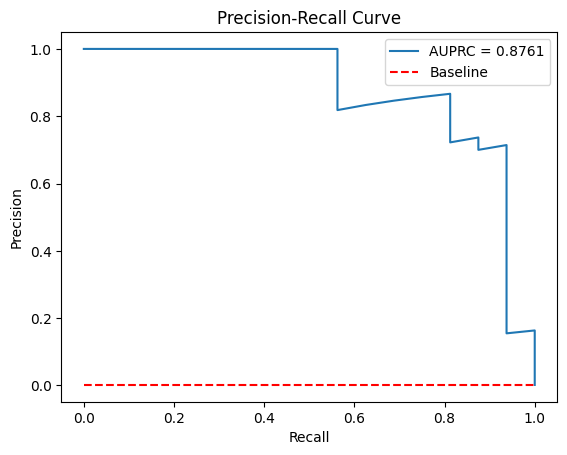


Confusion Matrix (threshold=0.5):
 [[11983     1]
 [    7     9]]
F1-score: 0.6923076923076923


In [5]:
from sklearn.metrics import confusion_matrix, f1_score, RocCurveDisplay

model = LGBMClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
    verbose=-1
)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# AUROC & AUPRC
auroc = roc_auc_score(y_test, y_pred_proba)
auprc = average_precision_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.plot([0,1],[y_test.mean(), y_test.mean()], 'r--', label='Baseline')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix at threshold = 0.5
y_pred = (y_pred_proba >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (threshold=0.5):\n", cm)
print("F1-score:", f1_score(y_test, y_pred))


# Conducts a causal analysis with DoWhy to estimate the effect of transaction amount on fraud.

Treatment group distribution (1=High Amount, 0=Low Amount):
treatment
0    45000
1    15000
Name: count, dtype: int64
--------------------------------------------------
Using 14 covariates for causal adjustment
Causal Graph:


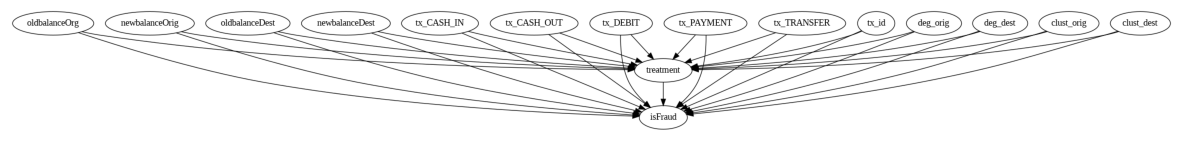

backdoor.propensity_score_matching: 0.0071
backdoor.propensity_score_weighting: 0.0245
backdoor.linear_regression: 0.0091

Refutation Test: Refute: Add a random common cause
Estimated effect:0.00908403219092645
New effect:0.009084131078025331
p value:0.76


 Baseline Model (No Embeddings):
AUROC: 0.9996975133511349
AUPRC: 0.9071562297855401

Confusion Matrix:
 [[11983     1]
 [    4    12]]
F1-score: 0.8275862068965517


In [6]:
# Causal Analysis Setup (Using amount as treatment)
high_amount_threshold = sample_df['amount'].quantile(0.75)
sample_df['treatment'] = (sample_df['amount'] > high_amount_threshold).astype(int)

# Sanity check
print("Treatment group distribution (1=High Amount, 0=Low Amount):")
print(sample_df['treatment'].value_counts())
print("-" * 50)

# Outcome
outcome = 'isFraud'

# Define Common Causes (EXCLUDE embeddings to prevent leakage)
feature_cols = [
    col for col in sample_df.columns
    if col not in ['isFraud','nameOrig','nameDest','treatment','amount']
       and not col.startswith("emb_")
]

print(f"Using {len(feature_cols)} covariates for causal adjustment")

# Build Causal Model
model_causal = CausalModel(
    data=sample_df,
    treatment='treatment',
    outcome=outcome,
    common_causes=feature_cols
)

# Visualize Graph
print("Causal Graph:")
model_causal._graph.view_graph(size="15,10")

# Identify and Estimate Effect with Multiple Methods
identified_estimand = model_causal.identify_effect(proceed_when_unidentifiable=True)

methods = [
    "backdoor.propensity_score_matching",
    "backdoor.propensity_score_weighting",
    "backdoor.linear_regression"
]

estimates = {}
for m in methods:
    est = model_causal.estimate_effect(identified_estimand, method_name=m)
    estimates[m] = est.value
    print(f"{m}: {est.value:.4f}")

# Sensitivity Analysis
res = model_causal.refute_estimate(
    identified_estimand,
    est,
    method_name="random_common_cause"
)
print("\nRefutation Test:", res)

# Predictive Evaluation (baseline, no embeddings)
X_base = sample_df[feature_cols]
y_base = sample_df['isFraud']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.2, stratify=y_base, random_state=42)

model_base = XGBClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    use_label_encoder=False, eval_metric='logloss'
)
model_base.fit(X_train_base, y_train_base)

y_pred_proba_base = model_base.predict_proba(X_test_base)[:,1]
y_pred_base = (y_pred_proba_base >= 0.5).astype(int)

print("\n Baseline Model (No Embeddings):")
print("AUROC:", roc_auc_score(y_test_base, y_pred_proba_base))
print("AUPRC:", average_precision_score(y_test_base, y_pred_proba_base))

cm_base = confusion_matrix(y_test_base, y_pred_base)
print("\nConfusion Matrix:\n", cm_base)
print("F1-score:", f1_score(y_test_base, y_pred_base))


# Demonstrates potential data leakage by training a model with all features, resulting in a perfect score.

In [8]:
# Encode Categorical IDs (nameOrig & nameDest)
df_with_embeddings = sample_df.copy()

# Simple integer encoding
for col in ['nameOrig', 'nameDest']:
    df_with_embeddings[col] = df_with_embeddings[col].astype('category').cat.codes

X_leak = df_with_embeddings.drop(columns=['isFraud'])
y_leak = df_with_embeddings['isFraud']

X_train_leak, X_test_leak, y_train_leak, y_test_leak = train_test_split(
    X_leak, y_leak, test_size=0.2, stratify=y_leak, random_state=42)

# Train Model
model_leak = XGBClassifier(
    n_estimators=300, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss'
)
model_leak.fit(X_train_leak, y_train_leak)

# Predictions
y_pred_proba_leak = model_leak.predict_proba(X_test_leak)[:,1]
y_pred_leak = (y_pred_proba_leak >= 0.5).astype(int)

#  Metrics
print("Variant WITH Embeddings (Possible Leakage):")
print("AUROC:", roc_auc_score(y_test_leak, y_pred_proba_leak))
print("AUPRC:", average_precision_score(y_test_leak, y_pred_proba_leak))

cm_leak = confusion_matrix(y_test_leak, y_pred_leak)
print("\nConfusion Matrix:\n", cm_leak)
print("F1-score:", f1_score(y_test_leak, y_pred_leak))


Variant WITH Embeddings (Possible Leakage):
AUROC: 1.0
AUPRC: 1.0

Confusion Matrix:
 [[11984     0]
 [    0    16]]
F1-score: 1.0


# Audits the baseline model for fairness using AIF360 to quantify bias across different groups.

In [9]:
# 1. Create a Synthetic Protected Attribute
median_amount = X_train['amount'].median()
X_train['high_value_customer'] = (X_train['amount'] > median_amount).astype(int)
X_test['high_value_customer'] = (X_test['amount'] > median_amount).astype(int)


# 2. Create AIF360 Datasets for the TEST set
# Create a binary prediction output (0 or 1) for the metric
y_pred_class = (y_pred > 0.5).astype(int)

# Combine X_test and y_test into a single dataframe for AIF360
df_test_aif = X_test.copy()
df_test_aif['isFraud'] = y_test

# This is the dataset with the TRUE outcomes
dataset_true = BinaryLabelDataset(
    df=df_test_aif,
    label_names=['isFraud'],
    protected_attribute_names=['high_value_customer']
)

# This is the dataset with the PREDICTED outcomes
df_pred_aif = X_test.copy()
df_pred_aif['isFraud'] = y_pred_class
dataset_pred = BinaryLabelDataset(
    df=df_pred_aif,
    label_names=['isFraud'],
    protected_attribute_names=['high_value_customer']
)


# 3. Calculate a Model Fairness Metric
# Initialize the ClassificationMetric
metric = ClassificationMetric(dataset_true, dataset_pred,
                              unprivileged_groups=[{'high_value_customer': 0}],
                              privileged_groups=[{'high_value_customer': 1}])

# Calculate Equal Opportunity Difference
equal_opportunity_diff = metric.equal_opportunity_difference()
sp_diff = metric.statistical_parity_difference()
ao_diff = metric.average_odds_difference()
di = metric.disparate_impact()

print(f"Equal Opportunity Difference: {equal_opportunity_diff:.4f}")
print(f"Statistical Parity Difference: {sp_diff:.4f}")
print(f"Average Odds Difference: {ao_diff:.4f}")
print(f"Disparate Impact: {di:.4f}")

Equal Opportunity Difference: -0.6429
Statistical Parity Difference: -0.0017
Average Odds Difference: -0.3215
Disparate Impact: 0.0000


# Applies the Reweighing technique to mitigate bias and compares the fairness of the new model to the baseline.

In [10]:
# 1. Setup: Create Synthetic Attribute & AIF360 Datasets
median_amount = X_train['amount'].median()
X_train['high_value_customer'] = (X_train['amount'] > median_amount).astype(int)
X_test['high_value_customer'] = (X_test['amount'] > median_amount).astype(int)

df_train_aif = X_train.copy()
df_train_aif['isFraud'] = y_train

dataset_train = BinaryLabelDataset(
    df=df_train_aif,
    label_names=['isFraud'],
    protected_attribute_names=['high_value_customer']
)

# 2. Learn Mitigation Weights from TRAINING data
RW = Reweighing(unprivileged_groups=[{'high_value_customer': 0}],
                privileged_groups=[{'high_value_customer': 1}])

dataset_train_transf = RW.fit_transform(dataset_train)

# 3. Train the New Model
model_rw = LGBMClassifier(n_estimators=200, max_depth=8, class_weight='balanced', n_jobs=-1)
model_rw.fit(X_train, y_train, sample_weight=dataset_train_transf.instance_weights)

# 4. Evaluate and Re-Audit the Mitigated Model
y_pred_rw = model_rw.predict_proba(X_test)[:,1]
y_pred_class_rw = (y_pred_rw > 0.5).astype(int)

print("--- Performance of Mitigated Model ---")
print(f"Post-Mitigation AUROC: {roc_auc_score(y_test, y_pred_rw):.4f}")
print(f"Post-Mitigation AUPRC: {average_precision_score(y_test, y_pred_rw):.4f}\n")

# Re-audit using the same ClassificationMetric
df_pred_aif_rw = X_test.copy()
df_pred_aif_rw['isFraud'] = y_pred_class_rw
dataset_pred_rw = BinaryLabelDataset(
    df=df_pred_aif_rw,
    label_names=['isFraud'],
    protected_attribute_names=['high_value_customer']
)

# We need the original true dataset for comparison
df_test_aif = X_test.copy()
df_test_aif['isFraud'] = y_test
dataset_true = BinaryLabelDataset(
    df=df_test_aif,
    label_names=['isFraud'],
    protected_attribute_names=['high_value_customer']
)

metric_rw = ClassificationMetric(dataset_true, dataset_pred_rw,
                                 unprivileged_groups=[{'high_value_customer': 0}],
                                 privileged_groups=[{'high_value_customer': 1}])

equal_opportunity_diff_rw = metric_rw.equal_opportunity_difference()

# Baseline metric (before reweighing)
metric_base = ClassificationMetric(dataset_true, dataset_pred,
                                   unprivileged_groups=[{'high_value_customer': 0}],
                                   privileged_groups=[{'high_value_customer': 1}])


# Baseline metrics (before reweighing)
metric_base = ClassificationMetric(dataset_true, dataset_pred,
                                   unprivileged_groups=[{'high_value_customer': 0}],
                                   privileged_groups=[{'high_value_customer': 1}])

equal_opportunity_diff_base = metric_base.equal_opportunity_difference()
sp_diff_base = metric_base.statistical_parity_difference()
ao_diff_base = metric_base.average_odds_difference()
di_base = metric_base.disparate_impact()

print("--- Baseline Fairness ---")
print(f"Equal Opportunity Difference: {equal_opportunity_diff_base:.4f}")
print(f"Statistical Parity Difference: {sp_diff_base:.4f}")
print(f"Average Odds Difference: {ao_diff_base:.4f}")
print(f"Disparate Impact: {di_base:.4f}")

# Fairness metrics (after reweighing)
equal_opportunity_diff_rw = metric_rw.equal_opportunity_difference()
sp_diff_rw = metric_rw.statistical_parity_difference()
ao_diff_rw = metric_rw.average_odds_difference()
di_rw = metric_rw.disparate_impact()

print("\n--- Fairness of Mitigated Model ---")
print(f"Equal Opportunity Difference: {equal_opportunity_diff_rw:.4f}")
print(f"Statistical Parity Difference: {sp_diff_rw:.4f}")
print(f"Average Odds Difference: {ao_diff_rw:.4f}")
print(f"Disparate Impact: {di_rw:.4f}")

# comparison
print("\n--- Fairness Comparison ---")
print(f"Baseline Equal Opportunity Difference: {equal_opportunity_diff_base:.4f}")
print(f"After Reweighing Equal Opportunity Difference: {equal_opportunity_diff_rw:.4f}")

--- Performance of Mitigated Model ---
Post-Mitigation AUROC: 0.9994
Post-Mitigation AUPRC: 0.8456

--- Baseline Fairness ---
Equal Opportunity Difference: -0.6429
Statistical Parity Difference: -0.0017
Average Odds Difference: -0.3215
Disparate Impact: 0.0000

--- Fairness of Mitigated Model ---
Equal Opportunity Difference: 0.2857
Statistical Parity Difference: -0.0013
Average Odds Difference: 0.1429
Disparate Impact: 0.1997

--- Fairness Comparison ---
Baseline Equal Opportunity Difference: -0.6429
After Reweighing Equal Opportunity Difference: 0.2857
